# MinHash Performance

Specifically, studying the false negative rates on the MinHash as a function of Set size and "Universal Set" size.

In [14]:
import random


def random_set(
    *,
    min_size: int,
    max_size: int,
    min_value: int = 0,
    max_value: int = 0xFFFFFFFF,
) -> set[int]:
    return set(random.randint(min_value, max_value) for _ in range(random.randint(min_size, max_size)))
 
def random_change(set_: set[int]) -> set[int]:
    new_set = set_.copy()
    if random.random() < 0.5 or len(new_set) <= 1:
        new_set.add(random.randint(0, 0xFFFFFFFF))
    else:
        new_set.remove(random.choice(tuple(new_set)))
    return new_set

In [46]:
from collections import defaultdict


random.seed(2)
sets = [random_set(min_size=5, max_size=40) for _ in range(50)]

connections: defaultdict[int, list[int]] = defaultdict(list)

for i in range(10000):
    curr_index = random.randint(0, len(sets) - 1)
    new_index = len(sets)
    sets.append(random_change(sets[curr_index]))
    connections[curr_index].append(new_index)
    connections[new_index].append(curr_index)
    
print("Max size: ", max(len(s) for s in sets))



Max size:  45


In [26]:
def find_nearest(set_index: int, radius: int) -> list[int]:
    visited: set[int] = set()
    queue: list[int] = [set_index]
    for _ in range(radius + 1):
        new_queue = []
        for index in queue:
            visited.add(index)
            new_queue.extend(connections[index])
        queue = new_queue
    return list(visited)


[449, 1315, 100, 876, 2318, 701, 30]

In [55]:
from min_hash import MinHasher, MinHash, compare

hasher = MinHasher(50)

hashes: list[MinHash] = [hasher(s) for s in sets]


In [41]:
def threshold_for_radius(set_index: int, radius: int) -> float:
    nearest = find_nearest(set_index, radius)
    target_hash = hashes[set_index]
    min_threshold = 0.0
    max_threshold = 1.0
    
    while max_threshold - min_threshold > 0.001:
        threshold = (min_threshold + max_threshold) / 2
        if all(compare(target_hash, hashes[i]) >= threshold for i in nearest):
            min_threshold = threshold
        else:
            max_threshold = threshold
            
    return min_threshold

def mean(values: list[float]) -> float:
    return sum(values) / len(values)


0.6897816754331683


(array([  62.,    0.,   11.,   83.,   67.,   73.,  125.,  155.,  178.,
         189.,  452.,  359.,  699.,  814.,  665.,  972., 2278., 1668.,
        1120.,   80.]),
 array([0.        , 0.04995117, 0.09990234, 0.14985352, 0.19980469,
        0.24975586, 0.29970703, 0.3496582 , 0.39960937, 0.44956055,
        0.49951172, 0.54946289, 0.59941406, 0.64936523, 0.69931641,
        0.74926758, 0.79921875, 0.84916992, 0.89912109, 0.94907227,
        0.99902344]),
 <BarContainer object of 20 artists>)

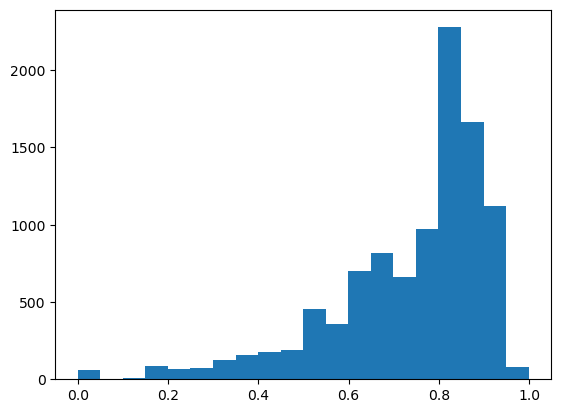

In [56]:
import matplotlib.pyplot as plt

thresholds = [threshold_for_radius(index, 3) for index in range(len(sets))]

plt.hist(thresholds, bins=20)

From the histogram, we can see that there isn't really a threshold or MinHash size that reduces the chance of false negatives once the number of element changes exceeds 2.